In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from camb import model, initialpower
from scipy.interpolate import interpn,interp1d
import corner
import emcee
import math
import matplotlib as mpl
from astropy.cosmology import w0waCDM

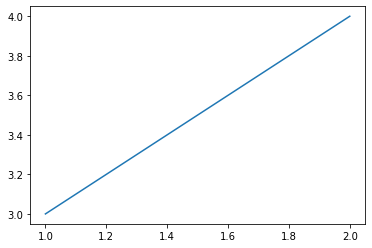

In [2]:
# importing from getdist on Perlmutter seems to break pyplot for me unless I do this weird thing

plt.plot([1,2],[3,4]);
plt.show()

In [ ]:
from getdist import plots, MCSamples

In [ ]:
plt.plot([1,2],[3,4]);
plt.show()

In [ ]:
mpl.rcParams.update({'font.size':22})

In [ ]:
# initial and base cosmologies

Kos = camb.CAMBparams();
h = 0.6781
Kos.set_cosmology(H0=h*100);
Kos0 = camb.CAMBparams();
Kos0.set_cosmology(H0=h*100);

In [ ]:
# interpolation to convert between camb.CAMBparams().InitPower.As and sigma_8

fax = []
S8  = []
ib  = 100 # number of interpolation bins
z   = 0.25

for i in range(ib+1):
    print("|",end='',flush=True)
    fac = 2*i/ib
    fax.append(fac)
    Kos = camb.CAMBparams();
    Kos.set_cosmology(H0=h*100);
    Kos.set_matter_power(redshifts=[z], kmax=2.0)
    results = camb.get_results(Kos)
    s8_ = results.get_sigma8()
    Kos.InitPower.As = (fac/s8_)*Kos.InitPower.As
    Kos.set_matter_power(redshifts=[z], kmax=2.0)
    results = camb.get_results(Kos)
    S8.append(results.get_sigma8())
S8 = np.array([t8[0] for t8 in S8])
f2s = interp1d(S8,fax)

In [ ]:
# functions that go into the theoretical void size spectrum

def X(r,dlv,results):
    D = np.abs(dlv)/(1.686+np.abs(dlv))
    return D*results.get_sigmaR(r)[0]/np.abs(dlv)

def f(r,dlv,results):
    S = 0.
    xx = X(r,dlv,results)
    D = np.abs(dlv)/(1.686+np.abs(dlv))
    j = 1
    sdd = np.inf
    while sdd>0.:
        sdd = np.exp((-1*(j*np.pi*xx)**2.)/2.)*j*np.pi*(xx**2)
        sd = sdd*np.sin(j*np.pi*D)
        S = S+sd
        j = j+1
    return 2*S

def dlns(r,w,results):
    rl = np.exp(np.log(r)-w/2.)
    rh = np.exp(np.log(r)+w/2.)
    s2l = results.get_sigmaR(rl)[0]
    s2h = results.get_sigmaR(rh)[0]
    return (np.log(s2h)-np.log(s2l))/(-1.*w)

def rL(r,dnlv):
    return r*((1+dnlv)**(1./3))

def dlnr(r,w,dnlv):
    rl = np.exp(np.log(r)-w/2.)
    rh = np.exp(np.log(r)+w/2.)
    r2l = rL(rl,dnlv)
    r2h = rL(rh,dnlv)
    return (np.log(r2h)-np.log(r2l))/(np.log(rh)-np.log(rl))

def V(r):
    return 4*np.pi*(r**3)/3.

def dndln(r,w,dnlv,results):
    dlv = 1.594*(1-((1+dnlv)**(-1./1.594)))
    return f(rL(r,dnlv),dlv,results)*dlns(rL(r,dnlv),w,results)*dlnr(r,w,dnlv)/V(r)

In [ ]:
# void size spectrum

def getPlots(delta,Om_m,s8,w0,wa,w,z,beff):
    Kos = camb.CAMBparams();
    h = 0.6781
    Kos.set_cosmology(H0=h*100);
    dnlv = delta/beff
    #Kos.omch2 = (Om_m-(Kos.ombh2/h**2)-(Kos.omnuh2/h**2))*(h**2)
    Kos.omch2 = Kos0.omch2*Om_m/Kos0.omegam
    Kos.ombh2 = Kos0.ombh2*Om_m/Kos0.omegam
    Kos.omnuh2 = Kos0.omnuh2*Om_m/Kos0.omegam
    Kos.DarkEnergy.set_params(w=w0,wa=wa)
    Kos.set_matter_power(redshifts=[z], kmax=2.0)
    results = camb.get_results(Kos)
    Kos.InitPower.As = (f2s(s8)/results.get_sigma8())*Kos.InitPower.As
    Kos.set_matter_power(redshifts=[z], kmax=2.0)
    results = camb.get_results(Kos)
    Kos2 = w0waCDM(H0=67.81,Om0=0.315,Ode0=0.685,w0=-1.,wa=0.)
    h2   = Kos2.H(z).value
    a2   = Kos2.angular_diameter_distance(z).value
    Kos3 = w0waCDM(H0=67.81,Om0=Om_m,Ode0=1.-Om_m,w0=w0,wa=wa)
    h3   = Kos3.H(z).value
    a3   = Kos3.angular_diameter_distance(z).value
    agr = ((h2/h3)**(1./3))*((a3/a2)**(2./3))
    A = np.array([dndln(i,w,dnlv,results) for i in np.logspace(np.log10(0.3),np.log10(30),100)])
    dN = np.array([dndln((0.5+(i/1.))/agr,w,dnlv,results)*(np.log((i+1)/1.)-np.log(i/1.)) for i in range(10,70)])
    DN = np.array([np.sum(dN[i:]) for i in range(len(dN))])
    #B = 9+np.log10(DN)
    return A,DN

In [ ]:
# create and save grid of theoretical spectra for interpolation
# this has to be done for every redshift bin
# this will take a while...

z_grid = 0.25

# nbins and ranges for all parameters; 0 bins for constant
nb_Omm = 15
rn_Omm = [0.1,1.]
nb_s8  = 20
rn_s8  = [0.6,1.1]
nb_w0  = 0
rn_w0  = [-1.,-1.]
nb_wa  = 0
rn_wa  = [0.,0.]

nb_beff = 20
rn_beff = [1.,3.]

bgrid = np.zeros((nb_beff+1,nb_Omm+1,nb_s8+1,nb_w0+1,nb_wa+1,60))
for hr in range(nb_beff+1):
    print("*",flush=True)
    Beff = rn_beff[0]+((rn_beff[1]-rn_beff[0])*hr/nb_beff)
    for ir in range(nb_Omm+1):
        print("|",end='',flush=True)
        Omega_m = rn_Omm[0] + ((rn_Omm[1]-rn_Omm[0])*ir/np.amax([1,nb_Omm]))
        for jr in range(nb_s8+1):
            s_8 = rn_s8[0] + ((rn_s8[1]-rn_s8[0])*jr/np.amax([1,nb_s8]))
            for kr in range(nb_w0+1):
                w_0 = rn_w0[0] + ((rn_w0[1]-rn_w0[0])*kr/np.amax([1,nb_w0]))
                for lr in range(nb_wa+1):
                    w_a = rn_wa[0] + ((rn_wa[1]-rn_wa[0])*lr/np.amax([1,nb_wa]))
                    A,B = getPlots(-0.7,Omega_m,s_8,w_0,w_a,0.000001,z,Beff)
                    bgrid[hr][ir][jr][kr][lr] = (10.**9)*B
    np.save("bgrid_z"+str(z_grid)+"_"+str(hr)+".npy",bgrid[hr])

In [ ]:
bgrid = np.zeros((nb_beff+1,nb_Omm+1,nb_s8+1,nb_w0+1,nb_wa+1,60))
for hr in range(nb_beff+1):
    bgr = np.load("bgrid_z"+str(z_grid)+"_"+str(hr)+".npy")
    bgrid[hr] = bgr.copy()
np.save("bgrid_z"+str(z_grid)+".npy",bgrid)

In [ ]:
# load in a grid

bgridd = np.load("bgrid_z0.25.npy")

In [ ]:
# create and save grid of theoretical spectra using the fiducial cosmology for interpolation

z_grid = 0.25

Bgrid = np.zeros((101,60))
for ir in range(101):
    print("|",end='',flush=True)
    Beff = 1.+(ir/50.)
    A,B = getPlots(-0.7,0.315,0.81,-1.0,0.0,0.000001,z_grid,Beff)
    Bgrid[ir] = (10.**9)*B
np.save("Bgrid_z"+str(z_grid)+".npy",Bgrid)

In [ ]:
# load in a fiducial grid

Bgrid = np.load("Bgrid_z0.25.npy")

In [ ]:
# create and save grid of relative comoving volumes for interpolation

z_grid = 0.25

cgrid = np.zeros((nb_Omm+1,nb_s8+1,nb_w0+1,nb_wa+1))
Kos2 = w0waCDM(H0=67.81,Om0=0.315,Ode0=0.685,w0=-1.,wa=0.)
mr2  = Kos2.comoving_distance(z_grid).value
for ir in range(nb_Omm+1):
    print("|",end='',flush=True)
    Omega_m = rn_Omm[0] + ((rn_Omm[1]-rn_Omm[0])*ir/np.amax([1,nb_Omm]))
        for kr in range(nb_w0+1):
            w_0 = rn_w0[0] + ((rn_w0[1]-rn_w0[0])*kr/np.amax([1,nb_w0]))
            for lr in range(nb_wa+1):
                w_a = rn_wa[0] + ((rn_wa[1]-rn_wa[0])*lr/np.amax([1,nb_wa]))
                Kos3 = w0waCDM(H0=67.81,Om0=Omega_m,Ode0=1.-Omega_m,w0=w_0,wa=w_a)
                mr3 = Kos3.comoving_distance(z_grid).value
                for jr in range(nb_s8+1):
                    cgrid[ir][jr][kr][lr] = (mr3/mr2)**3
np.save("cgrid_z"+str(z_grid)+".npy",cgrid)

In [ ]:
# load in a volume grid

cgrid = np.load("cgrid_z0.25.npy")

In [ ]:
# load in data void spectrum (currently 600-bin histogram from 10 to 70 Mpc/h) and survey volume (cubic Gpc/h)

vfv = 1.012268988
vfr = np.array([ 83,  92,  99, 143,  87, 180, 245, 160, 195, 204, 157, 268, 173,
       256, 319, 139, 257, 169, 212, 144, 219, 258, 128, 224, 116, 287,
       128, 242, 139, 229, 154, 199, 166, 221, 173, 123, 193, 127, 165,
       117, 136, 192, 123, 140, 161, 114, 104, 129, 122, 124, 145, 137,
       109, 109, 105, 151, 100,  81,  76, 120,  89,  60,  88,  84, 148,
        83,  67,  86,  70,  81,  68, 115,  77,  63,  72,  48,  64,  58,
        60,  62,  47,  63,  59,  60,  47,  64,  43,  54,  45,  59,  37,
        38,  52,  50,  34,  52,  43,  40,  38,  37,  40,  30,  41,  29,
        30,  16,  38,  36,  24,  34,  28,  17,  31,  24,  37,  18,  29,
        25,  17,  25,  29,  23,  29,  21,  26,  15,  19,  26,  17,  24,
        16,  23,  22,   8,  12,  12,  11,  11,  16,  10,  21,  18,  14,
        15,  16,  11,  12,  12,  18,  15,  15,   9,   6,   8,   8,   6,
         7,   7,   9,  11,   6,   7,   4,   7,   4,   5,   7,   4,   1,
         4,   7,   4,   6,   7,   7,   6,   2,   3,   4,   7,   4,   4,
         3,   4,   5,   3,   0,   2,   2,   6,   2,   4,   0,   2,   2,
         3,   2,   2,   2,   3,   1,   4,   2,   2,   1,   3,   4,   0,
         1,   1,   1,   0,   0,   3,   0,   3,   1,   1,   1,   0,   1,
         0,   0,   2,   1,   0,   1,   0,   0,   2,   0,   0,   2,   0,
         2,   0,   1,   1,   1,   0,   0,   1,   0,   0,   0,   0,   1,
         0,   0,   0,   0,   1,   1,   0,   0,   1,   0,   0,   1,   0,
         0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   1,   1,   0,   0,   0,   1,   1,   0,
         1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0])

In [ ]:
# set up MCMC for constraining F(B)

vrmin = 15. # minimum void radius considered
vrmax = 35. # maximum void radius considered
bsize = 5.  # void radius bin size for MCMC run - larger is faster

bnmin = int((vrmin-10.)/bsize)
bnmax = int((vrmax-10.)/bsize)


def logposterior(theta, data, sigma):
    lp = logprior(theta) # get the prior
    
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + loglikelihood(theta, data, sigma)


def loglikelihood(theta, data, sigma):
    Beff, dummy = theta
    Data = data[bnmin:bnmax]
    
    mdd = np.array([interpn((1.+2.*np.arange(101)/100.,0.+10.*np.arange(21)/20.),np.array([[Bgrid[ir][i] for jr in range(21)] for ir in range(101)]),theta) for i in range(60)])
    md = np.array([(mdd[int(bsize)*i]-mdd[int(bsize)*(i+1)])[0] for i in range(bnmin,bnmax)])
    rtrn = np.sum((Data*np.log(md*vfv))-(md*vfv)-np.array([math.lgamma(D+1) for D in Data]))
    if np.isnan(rtrn):
        return -np.inf
    else:
        return rtrn - 10000./(dummy+1)
    

def logprior(theta):
    lp = 0.
    
    Beff, dummy = theta
    
    Bmin = 1.
    Bmax = 3.
    dmin = 0.
    dmax = 10.
    
    lp = 0. if Bmin < Beff < Bmax else -np.inf
    lp += 0. if dmin < dummy < dmax else -np.inf
    
    return lp-(10000./(dummy+1.))


Nens = 50   # number of ensemble points

Bmin = 1.1  # lower range of prior
Bmax = 2.9   # upper range of prior
dmin = 0.1
dmax = 9.9

cini = np.random.uniform(Bmin, Bmax, Nens)
mini = np.random.uniform(dmin, dmax, Nens)

inisamples = np.array([cini, mini]).T # initial samples

ndims = inisamples.shape[1] # number of parameters/dimensions

Nburnin = 500   # number of burn-in samples
Nsamples = 500  # number of final posterior samples
Nburnin = 50
Nsamples = 100

data = np.array([np.sum(vfr[10*int(bsize)*i:10*int(bsize)*(i+1)]) for i in range(0,int(60/bsize)-1)])
sigma = np.sqrt(data)

argslist = (data, sigma)

In [ ]:
# run first MCMC

sampler = emcee.EnsembleSampler(Nens, ndims, logposterior, args=argslist)
sampler.run_mcmc(inisamples, Nsamples+Nburnin);
postsamples = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

In [ ]:
# MCMC results for F(B)

Beff = np.histogram(postsamples.T[0],bins=1000,range=(1,3))[1][np.argmax(np.histogram(postsamples.T[0],bins=1000,range=(1,3))[0])]

In [ ]:
# set up MCMC for cosmological parameters
# use same values as first MCMC

vrmin = 15.
vrmax = 35.
bsize = 5.

bnmin = int((vrmin-10.)/bsize)
bnmax = int((vrmax-10.)/bsize)
bgi   = int((Beff-1.)*10)
bga   = np.load("bgrid_z0.25_"+str(bgi)+".npy")
bgb   = np.load("bgrid_z0.25_"+str(bgi+1)+".npy")
bgrid = bga+((Beff-((bgi/10.)+1.))/0.1)*(bgb-bga)

def logposterior(theta, data, sigma):
    lp = logprior(theta) # get the prior
    
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + loglikelihood(theta, data, sigma)


def loglikelihood(theta, data, sigma):
    Omega_m, s_8, w_0, w_a = theta
    
    mdd = np.array([interpn((rn_Omm[0] + ((rn_Omm[1]-rn_Omm[0])*np.arange(nb_Omm+1)/np.amax([1,nb_Omm])),rn_s8[0] + ((rn_s8[1]-rn_s8[0])*np.arange(nb_s8+1)/np.amax([1,nb_s8])),rn_w0[0] + ((rn_w0[1]-rn_w0[0])*np.arange(nb_w0+1)/np.amax([1,nb_w0])),rn_wa[0] + ((rn_wa[1]-rn_wa[0])*np.arange(nb_wa+1)/np.amax([1,nb_wa]))),np.array([[[[[bgrid[ir][jr][kr][lr][i] for lr in range(nb_wa+1)] for kr in range(nb_w0+1)] for jr in range(nb_s8+1)] for ir in range(nb_Omm+1)]),theta) for i in range(60)])
    md = np.array([(mdd[int(bsize)*i]-mdd[int(bsize)*(i+1)])[0] for i in range(bnmin,bnmax)])
    vvm = interpn((rn_Omm[0] + ((rn_Omm[1]-rn_Omm[0])*np.arange(nb_Omm+1)/np.amax([1,nb_Omm])),rn_s8[0] + ((rn_s8[1]-rn_s8[0])*np.arange(nb_s8+1)/np.amax([1,nb_s8])),rn_w0[0] + ((rn_w0[1]-rn_w0[0])*np.arange(nb_w0+1)/np.amax([1,nb_w0])),rn_wa[0] + ((rn_wa[1]-rn_wa[0])*np.arange(nb_wa+1)/np.amax([1,nb_wa]))),np.array([[[[cgrid[ir][jr][kr][lr] for lr in range(nb_wa+1)] for kr in range(nb_w0+1)] for jr in range(nb_s8+1)] for ir in range(nb_Omm+1)]),theta)
    
    rtrn = np.sum((data*np.log(md*vfv*vvm))-(md*vfv*vvm)-np.array([math.lgamma(D+1) for D in data]))
    if np.isnan(rtrn):
        return -np.inf
    else:
        return rtrn
    

def logprior(theta):
    lp = 0.
    
    Omega_m, s_8, w_0, w_a = theta
    
    Omin = rn_Omm[0]+0.01*(rn_Omm[1]-rn_Omm[0]) # lower range of prior
    Omax = rn_Omm[1]-0.01*(rn_Omm[1]-rn_Omm[0])  # upper range of prior
    
    smin = rn_s8[0]+0.01*(rn_s8[1]-rn_s8[0])
    smax = rn_s8[1]-0.01*(rn_s8[1]-rn_s8[0])
    
    vmin = rn_w0[0]+0.01*(rn_w0[1]-rn_w0[0])
    vmax = rn_w0[1]-0.01*(rn_w0[1]-rn_w0[0])
    
    wmin = rn_wa[0]+0.01*(rn_wa[1]-rn_wa[0])
    wmax = rn_wa[1]-0.01*(rn_wa[1]-rn_wa[0])
    
    lp = 0. if Omin <= Omega_m <= Omax else -np.inf
    
    lp += 0. if smin <= s_8 <= smax else -np.inf
    
    lp += 0. if vmin <= w_0 <= vmax else -np.inf
    
    lp += 0. if wmin <= w_a <= wmax else -np.inf
    
    return lp


Nens = 100   # number of ensemble points

Omin = rn_Omm[0]+0.02*(rn_Omm[1]-rn_Omm[0]) # lower range of prior
Omax = rn_Omm[1]-0.02*(rn_Omm[1]-rn_Omm[0])  # upper range of prior
smin = rn_s8[0]+0.02*(rn_s8[1]-rn_s8[0])
smax = rn_s8[1]-0.02*(rn_s8[1]-rn_s8[0])
vmin = rn_w0[0]+0.02*(rn_w0[1]-rn_w0[0])
vmax = rn_w0[1]-0.02*(rn_w0[1]-rn_w0[0])
wmin = rn_wa[0]+0.02*(rn_wa[1]-rn_wa[0])
wmax = rn_wa[1]-0.02*(rn_wa[1]-rn_wa[0])

Oini = np.random.uniform(Omin, Omax, Nens)
sini = np.random.uniform(smin, smax, Nens)
vini = np.random.uniform(vmin, vmax, Nens)
wini = np.random.uniform(wmin, wmax, Nens)

inisamples = np.array([Oini, sini, vini, wini]).T # initial samples

ndims = inisamples.shape[1] # number of parameters/dimensions

Nburnin = 500   # number of burn-in samples
Nsamples = 500  # number of final posterior samples
Nburnin = 100
Nsamples = 500

data = np.array([np.sum(vfr[10*int(bsize)*i:10*int(bsize)*(i+1)]) for i in range(bnmin,bnmax)])
sigma = np.sqrt(data)

argslist = (data, sigma)

In [ ]:
# run second MCMC

sampler = emcee.EnsembleSampler(Nens, ndims, logposterior, args=argslist)
sampler.run_mcmc(inisamples, Nsamples+Nburnin);
postsamples = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

In [ ]:
# plot the results

names = ["Omega_m","s_8"]
labels =  ["\Omega_m","s_8"]
samples = MCSamples(samples=(postsamples.T[:2].T),names = names, labels = labels)
g = plots.get_subplot_plotter()
g.triangle_plot([samples], markers=[0.315,0.81],filled=True)
plt.show()